In [39]:
# Install required packages.
!pip install torch

import os
import torch
import numpy as np
from tqdm import tqdm 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.1+cu121


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [41]:
# import torch
# import pickle
# from torch_geometric.datasets import TUDataset

# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'cse493g1/project/data'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive

# dataset_path = os.path.join(FOLDERNAME, 'solutions_dataset_gnn_graphs.pkl')
# with open(dataset_path, 'rb') as f:
#     dataset = pickle.load(f)

from construct_gnn_dataset import SolutionDataset

dataset = SolutionDataset(root='../../data/raw')

In [42]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')



Dataset: SolutionDataset(5000):
Number of graphs: 5000
Number of features: 139


In [43]:
def printstats(index):
    data = dataset[index]  

    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [44]:
x1, y1 = printstats(0)
x2, y2 = printstats(-1)


Data(edge_index=[2, 165], name=[166], cooccurrences=[166, 139], num_nodes=166, x=[166, 139], y=[10])
Number of nodes: 166
Number of edges: 165
Average node degree: 0.99
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[-0.1187, -0.1187, -0.1187,  ..., -0.1187, -0.1187, -0.1187],
        [-0.1707, -0.1707, -0.1707,  ..., -0.1707, -0.1707, -0.1707],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        ...,
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        [-0.1515, -0.1515,  0.9832,  ...,  0.1190, -0.0980, -0.1515],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231]])
Data.y: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Data(edge_index=[2, 238], name=[239], cooccurrences=[239, 139], num_nodes=239, x=[239, 139], y=[10])
Number of nodes: 239
Number of edges: 238
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[-0.1187, -0.1187

In [ ]:
NODE_FEATURES = dataset.num_features
NUM_CLASSES = dataset[0].y.size(-1)

print(NODE_FEATURES)
print(NUM_CLASSES)


139
10


In [46]:
assert (len(dataset) % 10 == 0)
split = (len(dataset) * 9) // 10

train_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 != 0]
test_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 == 0]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of training graphs: 4500
Number of test graphs: 500


In [47]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    data = data.to(device)
    
    if (step) % 2500 == 0:
        print(f'Step {step}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

Step 0:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 145], name=[1], cooccurrences=[146, 139], num_nodes=146, x=[146, 139], y=[10], batch=[146], ptr=[2])

Step 2500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 310], name=[1], cooccurrences=[311, 139], num_nodes=311, x=[311, 139], y=[10], batch=[311], ptr=[2])



## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [50]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(NODE_FEATURES, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        x = global_mean_pool(x, batch)  
        
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


model = GCN(hidden_channels=250).to(device) 
print(model)

GCN(
  (conv1): GCNConv(139, 250)
  (conv2): GCNConv(250, 250)
  (conv3): GCNConv(250, 250)
  (conv4): GCNConv(250, 250)
  (conv5): GCNConv(250, 250)
  (lin): Linear(in_features=250, out_features=10, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [ ]:
EPOCHS = 30
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epoch_losses = {}
epoch_accuracies = {}

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Progress"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        yTrue = batch.y.float().reshape(1, 10)
        loss = criterion(out, yTrue)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(out, dim=1)  
        correct += (predicted == yTrue).sum().item()
        total += batch.y.size(0)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

print("Training completed.")


Epoch 1/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 256.80it/s]


Epoch 1/30, Loss: 2937.3693, Accuracy: 0.1003


Epoch 2/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 241.49it/s]


Epoch 2/30, Loss: 1367.9439, Accuracy: 0.1007


Epoch 3/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 243.63it/s]


Epoch 3/30, Loss: 1333.2073, Accuracy: 0.0997


Epoch 4/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 247.87it/s]


Epoch 4/30, Loss: 1154.9950, Accuracy: 0.1001


Epoch 5/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 229.28it/s]


Epoch 5/30, Loss: 1071.4497, Accuracy: 0.1001


Epoch 6/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 236.22it/s]


Epoch 6/30, Loss: 1124.1742, Accuracy: 0.0996


Epoch 7/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 243.46it/s]


Epoch 7/30, Loss: 955.9947, Accuracy: 0.0999


Epoch 8/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 241.45it/s]


Epoch 8/30, Loss: 966.5319, Accuracy: 0.0998


Epoch 9/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 252.43it/s]


Epoch 9/30, Loss: 980.8678, Accuracy: 0.1003


Epoch 10/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 261.39it/s]


Epoch 10/30, Loss: 831.9980, Accuracy: 0.1000


Epoch 11/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 259.89it/s]


Epoch 11/30, Loss: 884.4248, Accuracy: 0.0999


Epoch 12/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 261.86it/s]


Epoch 12/30, Loss: 941.3734, Accuracy: 0.1002


Epoch 13/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 244.42it/s]


Epoch 13/30, Loss: 968.4925, Accuracy: 0.1000


Epoch 14/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 235.52it/s]


Epoch 14/30, Loss: 864.2193, Accuracy: 0.1004


Epoch 15/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 250.21it/s]


Epoch 15/30, Loss: 865.3284, Accuracy: 0.0998


Epoch 16/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 234.49it/s]


Epoch 16/30, Loss: 918.4085, Accuracy: 0.1004


Epoch 17/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 236.66it/s]


Epoch 17/30, Loss: 851.5919, Accuracy: 0.0999


Epoch 18/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 234.39it/s]


Epoch 18/30, Loss: 838.1345, Accuracy: 0.1000


Epoch 19/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 246.35it/s]


Epoch 19/30, Loss: 785.4918, Accuracy: 0.1002


Epoch 20/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 248.84it/s]


Epoch 20/30, Loss: 898.8501, Accuracy: 0.0999


Epoch 21/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 249.74it/s]


Epoch 21/30, Loss: 856.9797, Accuracy: 0.1000


Epoch 22/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 244.89it/s]


Epoch 22/30, Loss: 923.5456, Accuracy: 0.1004


Epoch 23/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 243.89it/s]


Epoch 23/30, Loss: 892.3647, Accuracy: 0.0996


Epoch 24/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 240.77it/s]


Epoch 24/30, Loss: 909.9492, Accuracy: 0.0999


Epoch 25/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 254.00it/s]


Epoch 25/30, Loss: 926.3581, Accuracy: 0.1002


Epoch 26/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 254.37it/s]


Epoch 26/30, Loss: 848.3129, Accuracy: 0.1000


Epoch 27/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 247.56it/s]


Epoch 27/30, Loss: 847.2222, Accuracy: 0.1000


Epoch 28/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 249.86it/s]


Epoch 28/30, Loss: 935.6264, Accuracy: 0.1003


Epoch 29/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 242.78it/s]


Epoch 29/30, Loss: 961.1161, Accuracy: 0.1000


Epoch 30/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 247.29it/s]

Epoch 30/30, Loss: 886.5877, Accuracy: 0.1003
Training completed.


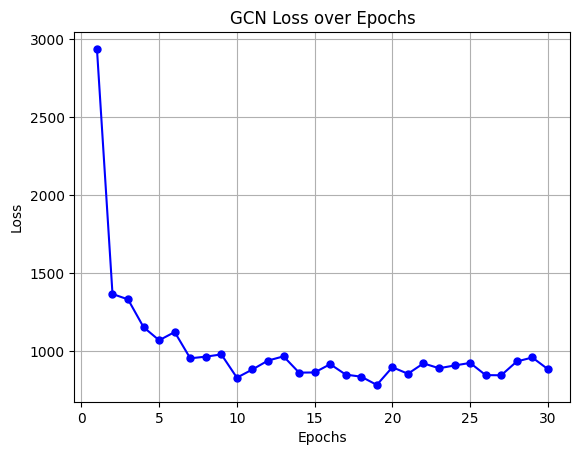

In [59]:
import matplotlib.pyplot as plt

epochs = list(epoch_losses.keys())
losses = list(epoch_losses.values())

plt.plot(epochs, losses, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GCN Loss over Epochs')
plt.grid(True)
plt.show()

In [52]:
MODEL_PATH = "GCNModel.pth"

In [53]:
torch.save(model, MODEL_PATH)

In [54]:
loaded_model = torch.load(MODEL_PATH)
loaded_model.eval()

GCN(
  (conv1): GCNConv(139, 250)
  (conv2): GCNConv(250, 250)
  (conv3): GCNConv(250, 250)
  (conv4): GCNConv(250, 250)
  (conv5): GCNConv(250, 250)
  (lin): Linear(in_features=250, out_features=10, bias=True)
)

In [56]:
def test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Progress"):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass            
            _, predicted = torch.max(out, 0)  # Get the index of the max log-probability
            total += batch.y.size(0)  # Total number of graphs
            correct += (predicted == batch.y).sum().item()  # Correct predictions

    accuracy = correct / total
    return accuracy

test_accuracy = test(loaded_model, test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Testing Progress: 100%|██████████| 500/500 [00:00<00:00, 515.71it/s]

Test Accuracy: 90.00%
